In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from collections import Counter
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
patient_counts = pd.read_csv(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient.csv",
    index_col=0,
    names=["patient_id", "cell_type", "count"],
    skiprows=1,
)

patient_counts["patient_id"] = patient_counts["patient_id"].str.replace("_sorted", "")

In [4]:
patient_counts

,patient_id,cell_type,count
0,23-714262*,discocyte,19373
1,23-714262*,granular,927
2,23-714262*,holly_leaf,774
3,23-714262*,sickle,357
4,23-714262*,echinocyte,251
5,24-711122,discocyte,13515
6,24-711122,granular,89
7,24-711122,holly_leaf,12
8,24-711122,sickle,97
9,24-711122,echinocyte,80


In [ ]:
patient_counts_agg = (
    patient_counts.groupby("patient_id").agg({"count": "sum"}).reset_index()
)

In [ ]:
patient_counts_agg

,patient_id,count
0,23-714262*,21682
1,24-711122,13793
2,24-Ramos-4122,18321
3,24-Ramos-44,15077
4,24-Survive-017,21937
5,24-Survive-018,19237
6,24-Survive-019,17799


I did not included all 24-711122 and 23-714262 discocytes in this dataset, so we need to get the counts out of general population

In [ ]:
patient_counts[
    (patient_counts["patient_id"] == "24-711122")
    & (
        patient_counts["cell_type"].isin(
            ["echinocyte", "granular", "holly_leaf", "sickle"]
        )
    )
].sum()

patient_id    24-71112224-71112224-71112224-711122
cell_type       granularholly_leafsickleechinocyte
count                                          278
dtype: object

In [ ]:
new_24_711122_disc = 13793 - 278
patient_counts.loc[
    (patient_counts["patient_id"] == "24-711122")
    & (patient_counts["cell_type"] == "discocyte"),
    "count",
] = new_24_711122_disc

In [ ]:
patient_counts[
    (patient_counts["patient_id"] == "23-714262")
    & (
        patient_counts["cell_type"].isin(
            ["echinocyte", "granular", "holly_leaf", "sickle"]
        )
    )
].sum()

patient_id    0
cell_type     0
count         0
dtype: object

In [ ]:
new_714262_disc = 21682 - 2309
patient_counts.loc[
    (patient_counts["patient_id"] == "23-714262*")
    & (patient_counts["cell_type"] == "discocyte"),
    "count",
] = new_714262_disc

In [ ]:
# Define the desired order of cell types
cell_type_order = ["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"]

# Convert the 'cell_type' column to a categorical type with the specified order
patient_counts["cell_type"] = pd.Categorical(
    patient_counts["cell_type"], categories=cell_type_order, ordered=True
)

# Sort the dataframe by 'patient_id' and 'cell_type'
patient_counts = patient_counts.sort_values(by=["patient_id", "cell_type"]).reset_index(
    drop=True
)
patient_counts

,patient_id,cell_type,count
0,23-714262*,discocyte,19373
1,23-714262*,granular,927
2,23-714262*,holly_leaf,774
3,23-714262*,sickle,357
4,23-714262*,echinocyte,251
5,24-711122,discocyte,13515
6,24-711122,granular,89
7,24-711122,holly_leaf,12
8,24-711122,sickle,97
9,24-711122,echinocyte,80


In [5]:
# Pivot the dataframe to get the counts for each cell type per patient
pivot_df = patient_counts.pivot(
    index="patient_id", columns="cell_type", values="count"
).fillna(0)

pivot_df

cell_type,discocyte,echinocyte,granular,holly_leaf,sickle
patient_id,,,,,
23-714262*,19373,251,927,774,357
24-711122,13515,80,89,12,97
24-Ramos-4122,17916,29,140,0,236
24-Ramos-44,14789,2,6,0,280
24-Survive-017,21547,283,83,0,24
24-Survive-018,18660,14,11,0,552
24-Survive-019,17368,9,18,0,404


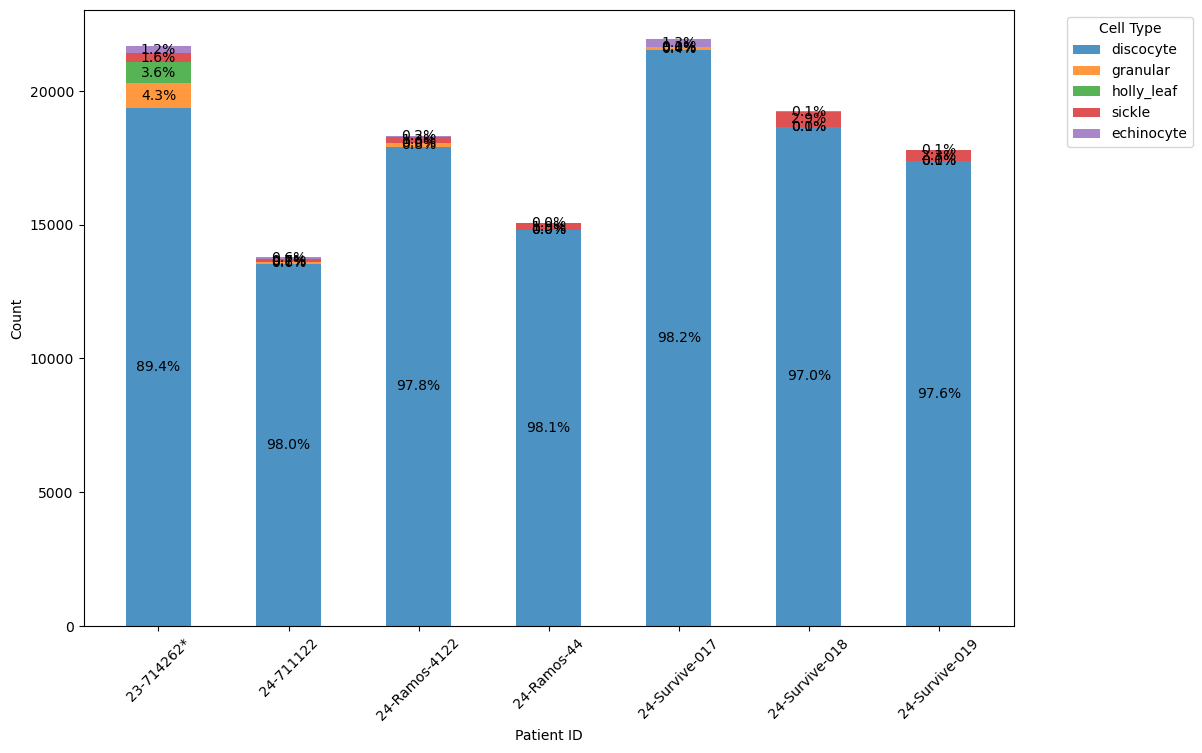

In [ ]:
# Calculate the total counts for each patient
df_total = pivot_df.sum(axis=1)

# Calculate the relative percentages
df_rel = pivot_df.div(df_total, axis=0) * 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each cell type as a stacked bar with thicker bars
bottom = np.zeros(len(pivot_df))
for cell_type in cell_type_order:
    ax.bar(
        pivot_df.index,
        pivot_df[cell_type],
        label=cell_type,
        bottom=bottom,
        width=0.5,
        alpha=0.8,
    )
    bottom += pivot_df[cell_type]

# Add percentage labels to the bars
for cell_type in df_rel:
    for i, (cs, ab, pc) in enumerate(
        zip(pivot_df.cumsum(axis=1)[cell_type], pivot_df[cell_type], df_rel[cell_type])
    ):
        ax.text(i, cs - ab / 2, str(np.round(pc, 1)) + "%", va="center", ha="center")

# Add labels and legend
ax.set_ylabel("Count")
ax.set_xlabel("Patient ID")
ax.legend(
    title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside

# Show the plot
plt.xticks(rotation=45)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient.png",
    bbox_inches="tight",
    dpi=300,
)

In [ ]:
# Define the new order of columns
new_order = ["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"]

# Reorder the columns
pivot_df = pivot_df[new_order]

# Display the DataFrame to verify the new order
pivot_df

# pivot_df.to_csv("/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient_pivot.csv")

In [ ]:
pivot_df.aggregate(["sum"]).to_csv(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient_pivot_sum.csv"
)

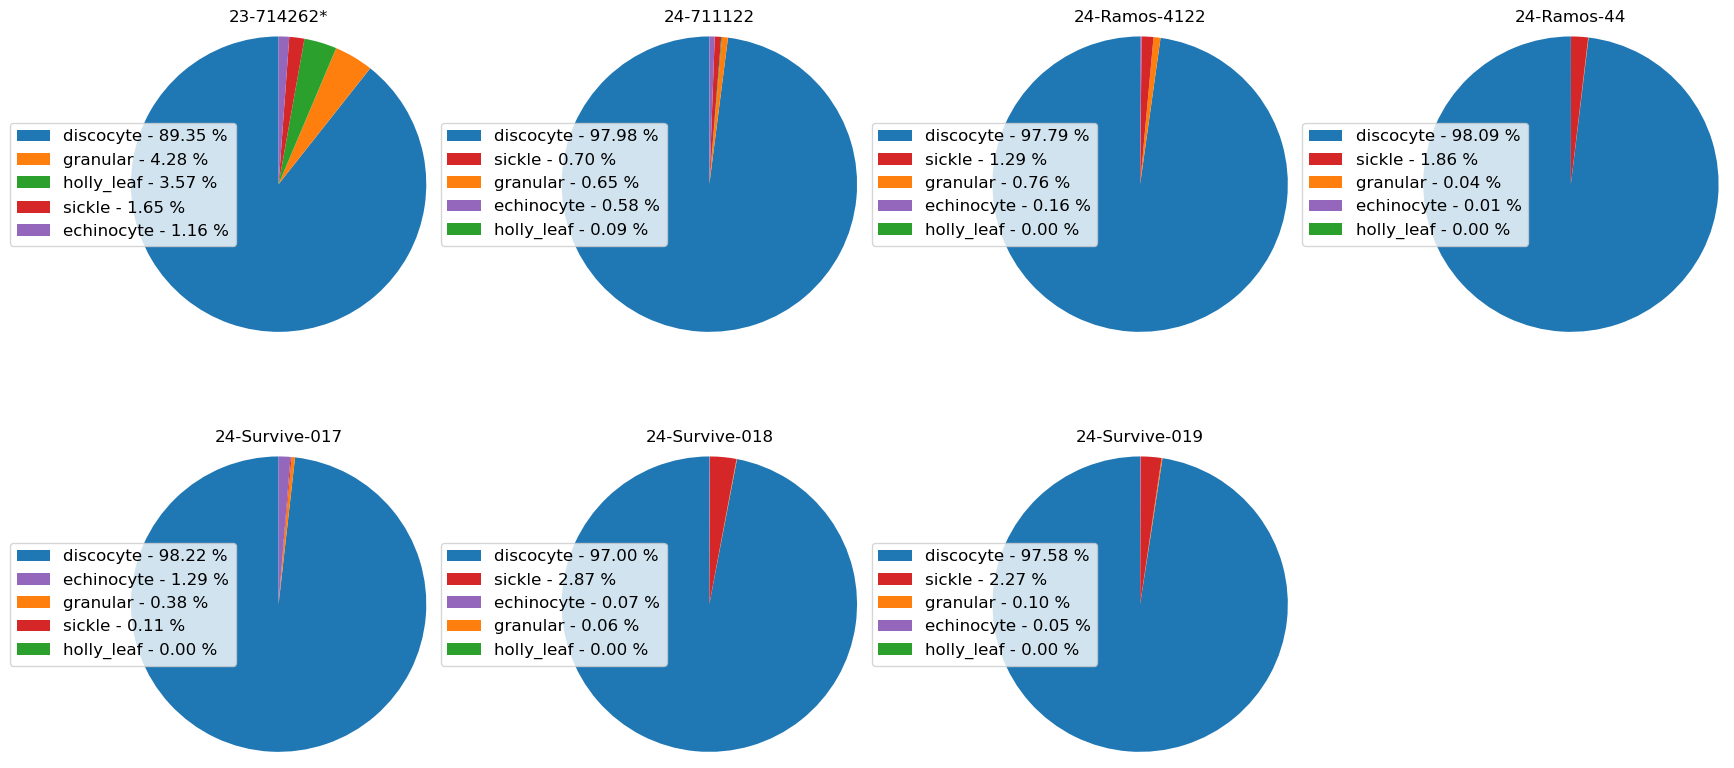

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the total counts for each patient
df_total = pivot_df.sum(axis=1)

# Calculate the relative percentages
df_rel = pivot_df.div(df_total, axis=0) * 100

# Create a figure with subplots for each patient
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot a pie chart for each patient
for i, patient_id in enumerate(pivot_df.index):
    ax = axes[i]
    y = pivot_df.loc[patient_id].values
    porcent = 100.0 * y / y.sum()
    patches, texts = ax.pie(y, startangle=90, radius=1.2)
    labels = [
        "{0} - {1:1.2f} %".format(i, j) for i, j in zip(pivot_df.columns, porcent)
    ]

    # Sort legend
    patches, labels, dummy = zip(
        *sorted(zip(patches, labels, y), key=lambda x: x[2], reverse=True)
    )

    ax.legend(
        patches, labels, loc="center left", bbox_to_anchor=(-0.4, 0.5), fontsize=12
    )  # Increased fontsize and moved legend outside left
    ax.set_title(patient_id)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout with padding
plt.subplots_adjust(left=0.1, right=0.9, wspace=0.4)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient_pie.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

<Figure size 1200x800 with 0 Axes>

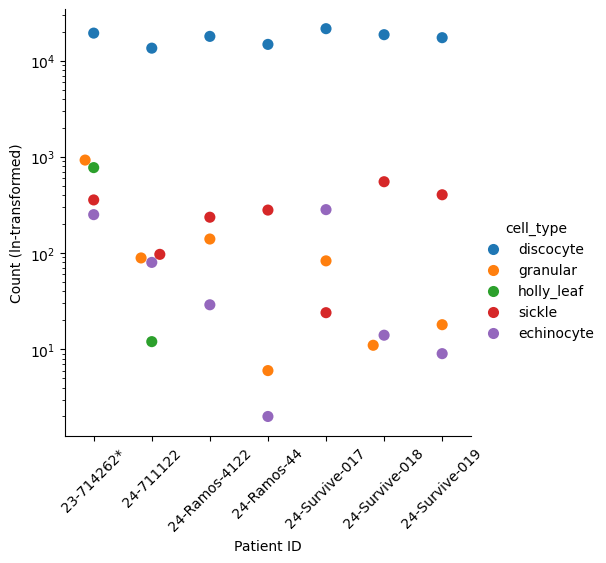

In [13]:
import seaborn as sns

# Create a barplot with thicker bars
plt.figure(figsize=(12, 8))
g = sns.catplot(
    kind="swarm",
    data=patient_counts,
    x="patient_id",
    y="count",
    hue="cell_type",
    log_scale=True,
    size=8,
)

# Add labels and legend
plt.ylabel("Count (ln-transformed)")
plt.xlabel("Patient ID")
plt.xticks(rotation=45)
# plt.legend(
#     title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
# )
g.despine(right=True)

plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient_ln.png",
    bbox_inches="tight",
    dpi=300,
)

In [14]:
patient_counts[patient_counts["cell_type"] == "sickle"]

,patient_id,cell_type,count
3,23-714262*,sickle,357
8,24-711122,sickle,97
13,24-Ramos-4122,sickle,236
18,24-Ramos-44,sickle,280
23,24-Survive-017,sickle,24
28,24-Survive-018,sickle,552
33,24-Survive-019,sickle,404


In [7]:
# patient_counts.to_csv(
#     "/home/t.afanasyeva/deep_learning_anaemias/output/250205_cell_count_per_patient_adjsuted.csv"
# )
del patient_counts

In [16]:
pivot_df.sum()

cell_type
discocyte     123168
granular        1274
holly_leaf       786
sickle          1950
echinocyte       668
dtype: int64

In [ ]:
import tensorflow as tf

# import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

2025-02-08 14:23:12.041434: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 14:23:12.650434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 14:23:12.799431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 14:23:12.847489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 14:23:13.224955: I tensorflow/core/platform/cpu_feature_guar

In [10]:
# Initialize lists to hold images and labels
X = []
y = []
z = []

# Define the directory path
directory_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/combined"

# Iterate over each folder in the directory
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    if os.path.isdir(folder_path):
        # Iterate over each file in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                # Load the image
                img = image.load_img(
                    file_path, color_mode="grayscale", target_size=(64, 64)
                )
                img_array = image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize the image

                # Append the image, label, and file name to the lists
                X.append(img_array)
                y.append(folder_name)
                z.append(file_name)

# Convert lists to numpy arrays
X = np.array([x.ravel() for x in X])
y = np.array(y)

In [11]:
X.shape, y.shape

((100259, 4096), (100259,))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Define the RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(
    sampling_strategy={
        "discocyte": 3000,
        "echinocyte": 664,
        "granular": 1271,
        "holly_leaf": 785,
        "sickle": 1946,
    },
    random_state=42,
)

# Fit and resample the data
X_resampled, y_resampled = rus.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))


# Get the indices of the original samples
original_indices = rus.sample_indices_
z_resampled = [z[i] for i in original_indices]

[('discocyte', 3000), ('echinocyte', 664), ('granular', 1271), ('holly_leaf', 785), ('sickle', 1946)]


In [14]:
directory_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"
image_shape = (64, 64)
for i, img in enumerate(X_resampled):
    img = img.reshape(image_shape)
    folder = os.path.join(directory_path, y_resampled[i])
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_path = os.path.join(folder, z_resampled[i])
    plt.imsave(file_path, img, cmap="gray")

Checking if the correct hashes are kept per file

9da369c90897c32ee7bf21a4a10adebb.png


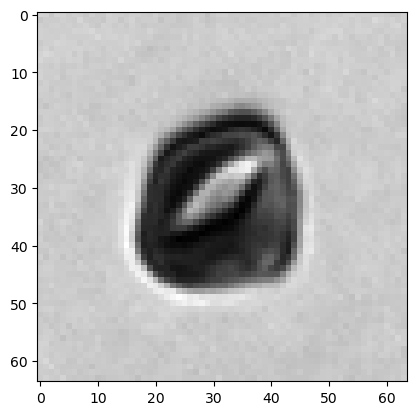

In [16]:
# Reshape the flattened image array back to its original shape
image_shape = (64, 64)
image = X_resampled[7].reshape(image_shape)

print(z_resampled[8])
# Display the image using OpenCV
plt.imshow(image, cmap="gray")

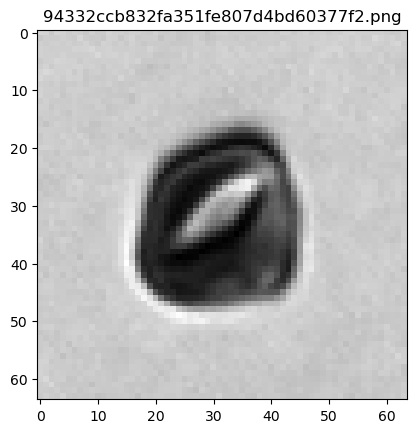

In [17]:
file_to_check = "94332ccb832fa351fe807d4bd60377f2.png"
folder_to_check = (
    "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/combined/discocyte"
)
file_path_to_check = os.path.join(folder_to_check, file_to_check)

file_exists = os.path.exists(file_path_to_check)
file_exists
if file_exists:
    img = plt.imread(file_path_to_check)
    plt.imshow(img, cmap="gray")
    plt.title(file_to_check)
    plt.show()
else:
    print(f"File {file_to_check} does not exist in the folder {folder_to_check}.")

Generating extra oversampled files with os_prefix

In [26]:
# # Initialize lists to hold images and labels
# X = []
# y = []
# z = []

# # Define the directory path
# directory_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

# # Iterate over each folder in the directory
# for folder_name in os.listdir(directory_path):
#     folder_path = os.path.join(directory_path, folder_name)
#     if os.path.isdir(folder_path):
#         # Iterate over each file in the folder
#         for file_name in os.listdir(folder_path):
#             file_path = os.path.join(folder_path, file_name)
#             if file_name.endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
#                 # Load the image using matplotlib
#                 img = plt.imread(file_path)
#                 # Append the image, label, and file name to the lists
#                 X.append(img_array)
#                 y.append(folder_name)
#                 z.append(file_name)

# # Convert lists to numpy arrays
# X_resampled = np.array([x.ravel() for x in X])
# y_resampled = np.array(y)
# z_resampled = np.array(z)

In [20]:
from imblearn.over_sampling import RandomOverSampler

# Define the RandomOverSampler with the desired sampling strategy
ros = RandomOverSampler(
    sampling_strategy={
        "discocyte": 3000,
        "echinocyte": 1000,
        "granular": 2000,
        "holly_leaf": 1000,
        "sickle": 2000,
    },
    random_state=42,
)

# Fit and resample the data
X_oversampled, y_oversampled = ros.fit_resample(X_resampled, y_resampled)
ros_indices = ros.sample_indices_
z_oversampled = [z_resampled[i] for i in ros_indices]

print(sorted(Counter(y_oversampled).items()))

[('discocyte', 3000), ('echinocyte', 1000), ('granular', 2000), ('holly_leaf', 1000), ('sickle', 2000)]


In [28]:
from collections import Counter

# Count the occurrences of each file name in z_oversampled
file_counts = Counter(z_oversampled)

# Find duplicates
duplicates = [file for file, count in file_counts.items() if count > 1]

print(f"Number of replicas: {len(duplicates)}")
print("Duplicate files:", duplicates)

Number of replicas: 1741
Duplicate files: ['426ec00ff00cb39cfcb93ae6f407548e.png', 'a8fa63ddffb2306eee91baf3b9478090.png', '21fec63dab7ddc23f587bf690f639197.png', '41cfbf0571fc1cf5078db15a319ded48.png', 'd4240cb1f2aea97d4544b838fae0b2ec.png', '293b16d5e51b3cb848c3be7d76161771.png', '9d7e622ebef195a89068eb80f6bc735d.png', 'e04e7352714ec5945f1759897b6d86cd.png', '9bf1e17ec0e59f3ac0846caa7a4c9c90.png', '7da70703028c2160a588120fe0b35ddf.png', '34f9dd31ae0b6ed027a4957d658d1101.png', '1a1ba3b11124c34c37772de35f7c600c.png', '16b6157ddfa7a47bcc4e57582b100859.png', '207f58d9dff1e3c9f3245e201214664c.png', '8b36d4243612868cbb50599133132316.png', '006d370a696394f8501bf13e04729eda.png', '9fb21ed2bead5601e275db6804c0f21b.png', '2dc87c5aa0cd571acc24f20959172a26.png', '8ea93da9ff7465a159c4ee90daf15404.png', 'a08dc46d4eea103f5747dbf85bf2d321.png', 'd59ee0ff93641b8885578da05a5ee87d.png', '389c0b376d33532b73d69e6f9b2f6c26.png', '12f5824a573d7848fbd41435ac375640.png', 'b1c789d477d2f9869096aa18c1a727d5.png

In [21]:
import json

# Create a dictionary to map original file names to resampled file names
file_name_mapping = {}

# Define the directory path for saving oversampled images
save_directory_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

# Iterate over each oversampled image and save it with the specified prefix
for i, image in enumerate(X_oversampled):
    image = image.reshape(image_shape)
    folder = os.path.join(save_directory_path, y_oversampled[i])
    if not os.path.exists(folder):
        os.makedirs(folder)

    original_file_name = z_oversampled[i]
    file_path = os.path.join(folder, original_file_name)

    # Check if the file already exists
    if os.path.exists(file_path):
        file_name = f"os_{original_file_name}"
        counter = 1
        while os.path.exists(os.path.join(folder, file_name)):
            file_name = f"os{counter}_{original_file_name}"
            counter += 1
        file_path = os.path.join(folder, file_name)
    else:
        file_name = original_file_name

    plt.imsave(file_path, image, cmap="gray")

    # Update the mapping dictionary
    file_name_mapping[original_file_name] = file_name

# Save the mapping dictionary to a file for future reference
mapping_file_path = (
    "/home/t.afanasyeva/deep_learning_anaemias/output/file_name_mapping.json"
)
with open(mapping_file_path, "w") as f:
    json.dump(file_name_mapping, f)

In [4]:
# Initialize lists to hold images and labels
X = []
y = []
z = []

# Define the directory path
directory_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

# Iterate over each folder in the directory
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    if os.path.isdir(folder_path):
        # Iterate over each file in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                # Load the image
                img = tf_image.load_img(
                    file_path, color_mode="grayscale", target_size=(64, 64)
                )
                img_array = tf_image.img_to_array(img)

                # Append the image, label, and file name to the lists
                X.append(img_array)
                y.append(folder_name)
                z.append(file_name)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [5]:
class_counts = Counter(y)
print(class_counts)

Counter({'discocyte': 3000, 'granular': 2000, 'sickle': 2000, 'echinocyte': 1000, 'holly_leaf': 1000})


In [64]:
X[0].shape

(64, 64, 1)

In [ ]:
X[0]

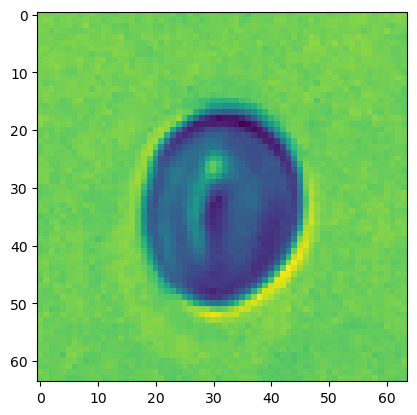

In [6]:
plt.imshow(X[0])

In [9]:
# Get the indices of the images labeled as "granular"
echinocyte_indices = np.where(y == "echinocyte")[0]

# Filter the X array to get only the images labeled as "granular"
X_echinocyte = X[echinocyte_indices]

X_echinocyte.shape

(1000, 64, 64, 1)

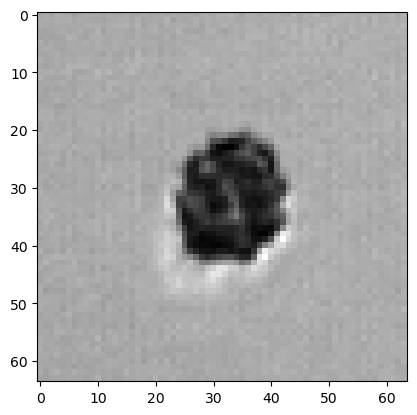

In [10]:
plt.imshow(X_echinocyte[0], cmap="gray")

pipeline for echinocytes and holly leafs

In [ ]:
# Iterate over each folder in the directory
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

ds = tf.keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="categorical",
    class_names=["echinocyte", "holly_leaf"],
    color_mode="grayscale",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    subset=None,
    data_format="channels_last",
    verbose=True,
)
class_names = ds.class_names

data_augmentation1 = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)
data_augmentation2 = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)
data_augmentation3 = Sequential(
    [
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)

ds = ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTOTUNE)

ds1 = ds.map(
    lambda x, y: (data_augmentation1(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)
ds2 = ds.map(
    lambda x, y: (data_augmentation2(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)
ds3 = ds.map(
    lambda x, y: (data_augmentation3(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
)


ds_list = [ds1, ds2, ds3]
ds_new = tf.data.Dataset.from_tensor_slices(ds_list)
ds_aug = ds_new.interleave(
    lambda x: x,
    cycle_length=1,
    num_parallel_calls=tf.data.AUTOTUNE,
).shuffle(1000)

Found 2000 files belonging to 2 classes.


In [38]:
size = sum(1 for _ in ds_aug)
print("Dataset size:", size)

Dataset size: 6000


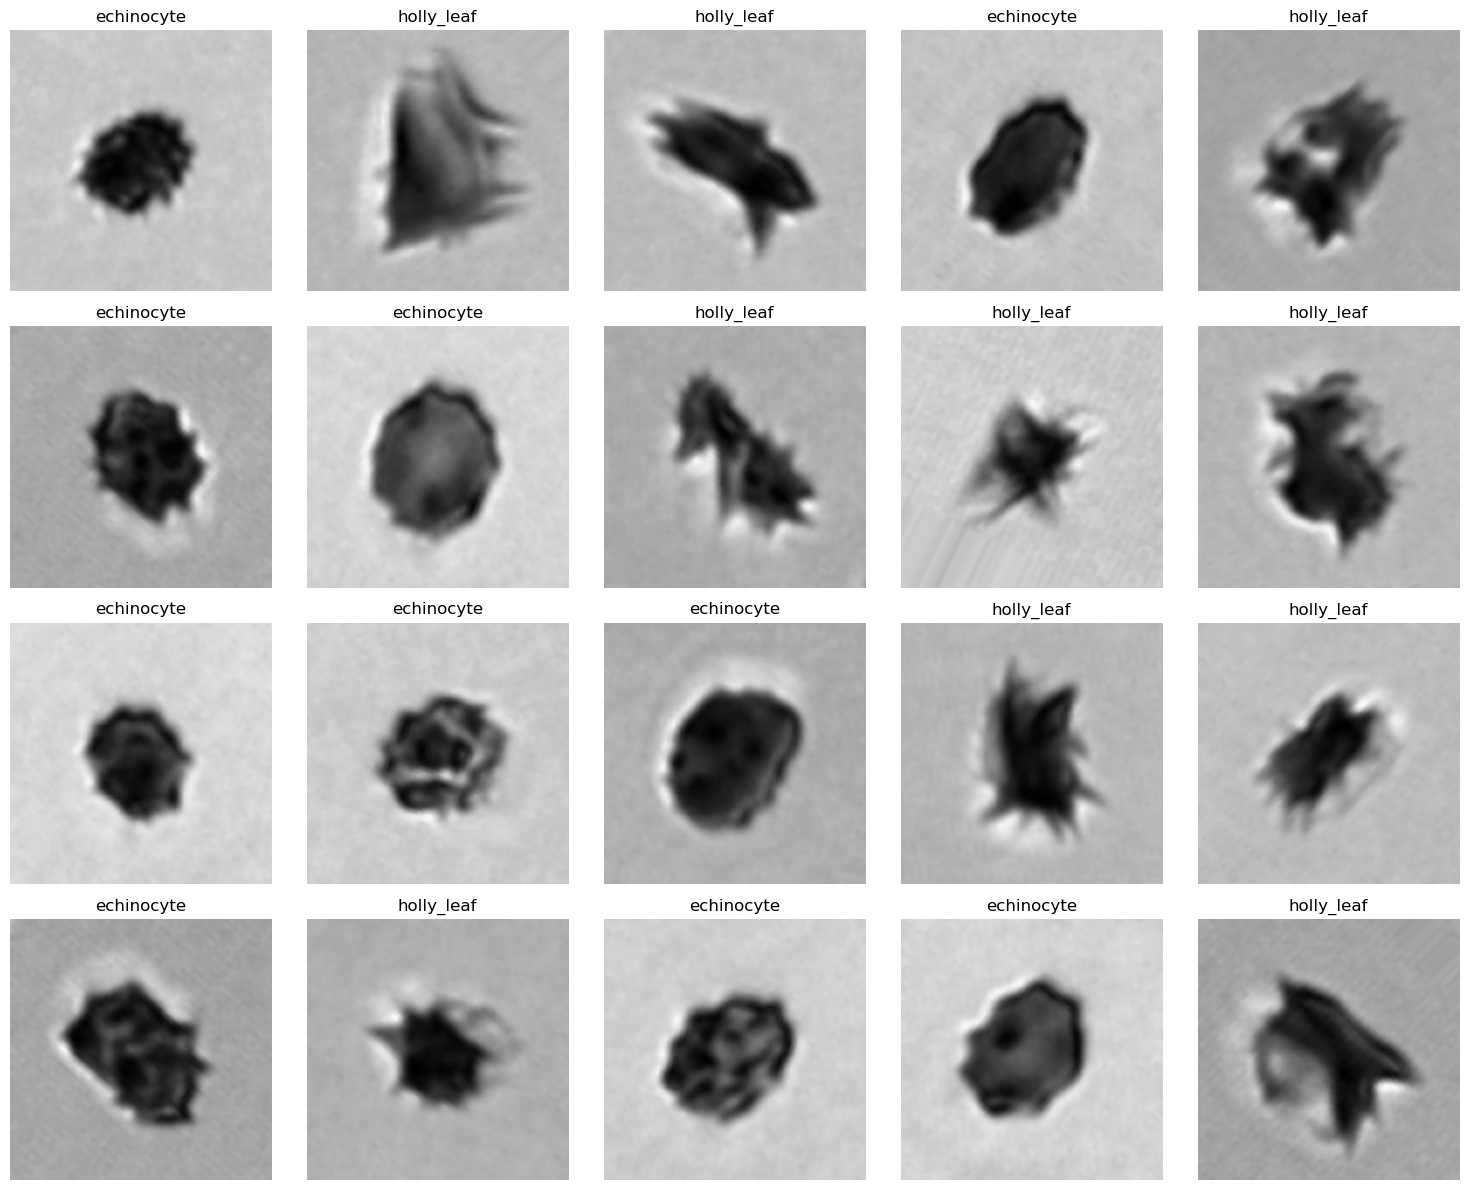

In [ ]:
# Create a figure to display the images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Iterate over the dataset and display 20 random images
for i, (image, label) in enumerate(ds_aug.take(20)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis("off")
    ax.set_title(class_names[tf.argmax(label).numpy()])

plt.tight_layout()
plt.show()

In [40]:
output_dir = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/augmented"

for i, (image, label) in enumerate(ds_aug):
    class_index = tf.argmax(label).numpy()
    folder_name = class_names[class_index]
    folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    save_path = os.path.join(folder_path, f"{i}.png")
    plt.imsave(save_path, image.numpy().astype(np.uint8))

Aug for sickle and granular

In [ ]:
# Iterate over each folder in the directory
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

ds = tf.keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="categorical",
    class_names=["sickle", "granular"],
    color_mode="grayscale",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    subset=None,
    data_format="channels_last",
    verbose=True,
)
class_names = ds.class_names

data_augmentation1 = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)

data_augmentation2 = Sequential(
    [
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)

ds = ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTOTUNE)

# Shuffle the datasets
ds1 = ds.map(
    lambda x, y: (data_augmentation1(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
).shuffle(1000)

ds2 = ds.map(
    lambda x, y: (data_augmentation2(x, training=True), y),
    num_parallel_calls=AUTOTUNE,
).shuffle(1000)

# Take half of each dataset
ds = ds.take(len(ds2) // 2)
ds1 = ds1.take(len(ds1) // 2)
ds2 = ds2.take(len(ds2) // 2)


ds_list = [ds, ds1, ds2]
ds_new = tf.data.Dataset.from_tensor_slices(ds_list)
ds_aug = ds_new.interleave(
    lambda x: x,
    cycle_length=1,
    num_parallel_calls=tf.data.AUTOTUNE,
).shuffle(1000)

Found 4000 files belonging to 2 classes.


In [42]:
size = sum(1 for _ in ds_aug)
print("Dataset size:", size)

Dataset size: 6000


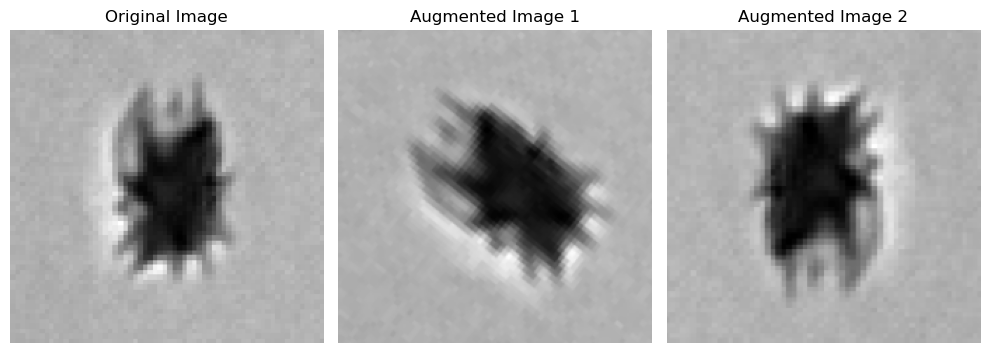

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define your augmentation pipelines
data_augmentation1 = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)

data_augmentation2 = Sequential(
    [
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0.05), width_factor=(-0.1, -0.05)),
    ]
)

# Load a sample image (replace with your image path)
img_path = "/home/t.afanasyeva/deep_learning_anaemias/resources/train/holly_leaf/2f07f9e06ec66f56034f413a8a66e551.png"  # Change to your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Apply augmentations
augmented_image1 = data_augmentation1(img_array)
augmented_image2 = data_augmentation2(img_array)

# Plot original and augmented images
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img_array[0].astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Augmented Image 1
plt.subplot(1, 3, 2)
plt.imshow(augmented_image1[0].numpy().astype("uint8"))
plt.title("Augmented Image 1")
plt.axis("off")

# Augmented Image 2
plt.subplot(1, 3, 3)
plt.imshow(augmented_image2[0].numpy().astype("uint8"))
plt.title("Augmented Image 2")
plt.axis("off")

plt.tight_layout()
plt.show()

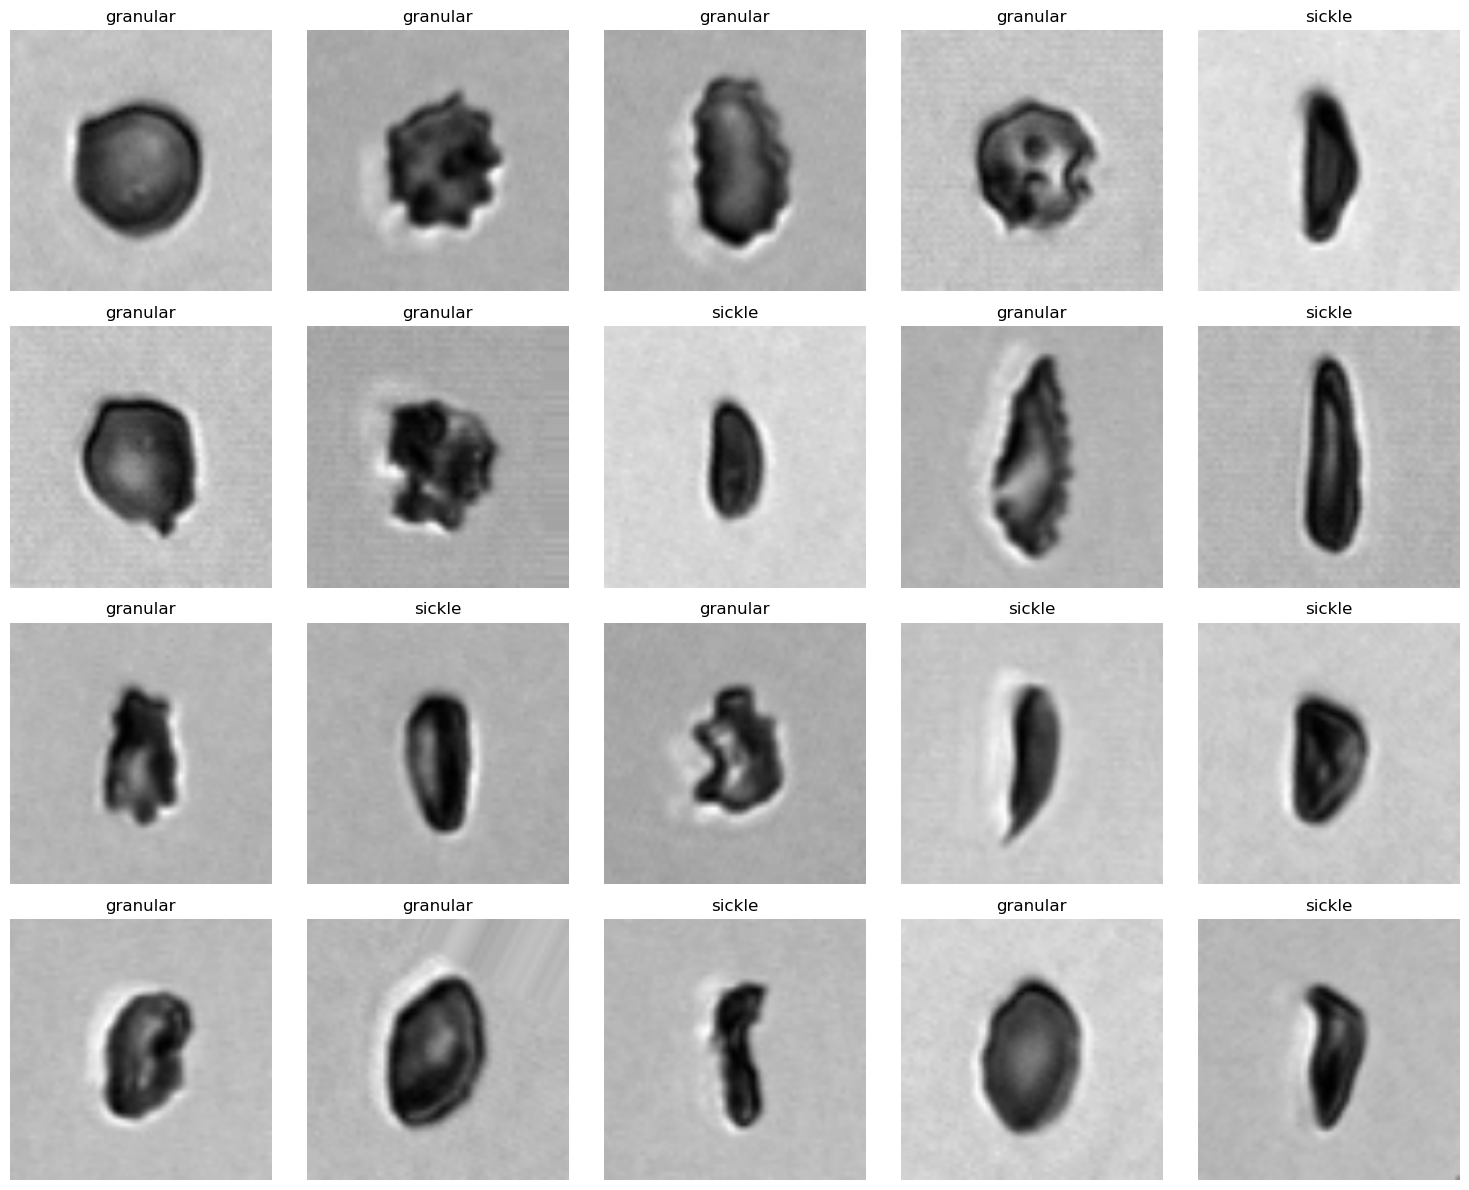

In [ ]:
# Create a figure to display the images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Iterate over the dataset and display 20 random images
for i, (image, label) in enumerate(ds_aug.take(20)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis("off")
    ax.set_title(class_names[tf.argmax(label).numpy()])

plt.tight_layout()
plt.show()

In [44]:
output_dir = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/augmented"

for i, (image, label) in enumerate(ds_aug):
    class_index = tf.argmax(label).numpy()
    folder_name = class_names[class_index]
    folder_path = os.path.join(output_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    save_path = os.path.join(folder_path, f"{i}.png")
    plt.imsave(save_path, image.numpy().astype(np.uint8))

2025-02-08 15:47:46.704974: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import shutil
import os

# Define source and destination directories
src_dir = "/home/t.afanasyeva/deep_learning_anaemias/resources/train/discocyte"
dst_dir = (
    "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/augmented/discocyte"
)

# Create the destination directory if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# Copy all PNG files from the source to the destination directory
for file_name in os.listdir(src_dir):
    if file_name.endswith(".png"):
        src_file = os.path.join(src_dir, file_name)
        dst_file = os.path.join(dst_dir, file_name)
        shutil.copy(src_file, dst_file)

In [ ]:
IMG_SIZE = 224

In [5]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/augmented"
ds = tf.keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="categorical",
    class_names=[
        "discocyte",
        "holly_leaf",
        "granular",
        "sickle",
        "echinocyte",
    ],
    color_mode="rgb",
    batch_size=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=93,
    subset=None,
    data_format="channels_last",
    verbose=True,
)
class_names = ds.class_names

Found 15000 files belonging to 5 classes.


2025-02-09 00:27:24.432232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [ ]:
for x, y in ds.take(1):
    print(x.shape)
    print(y.shape)
    print(y)

(224, 224, 3)
(5,)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


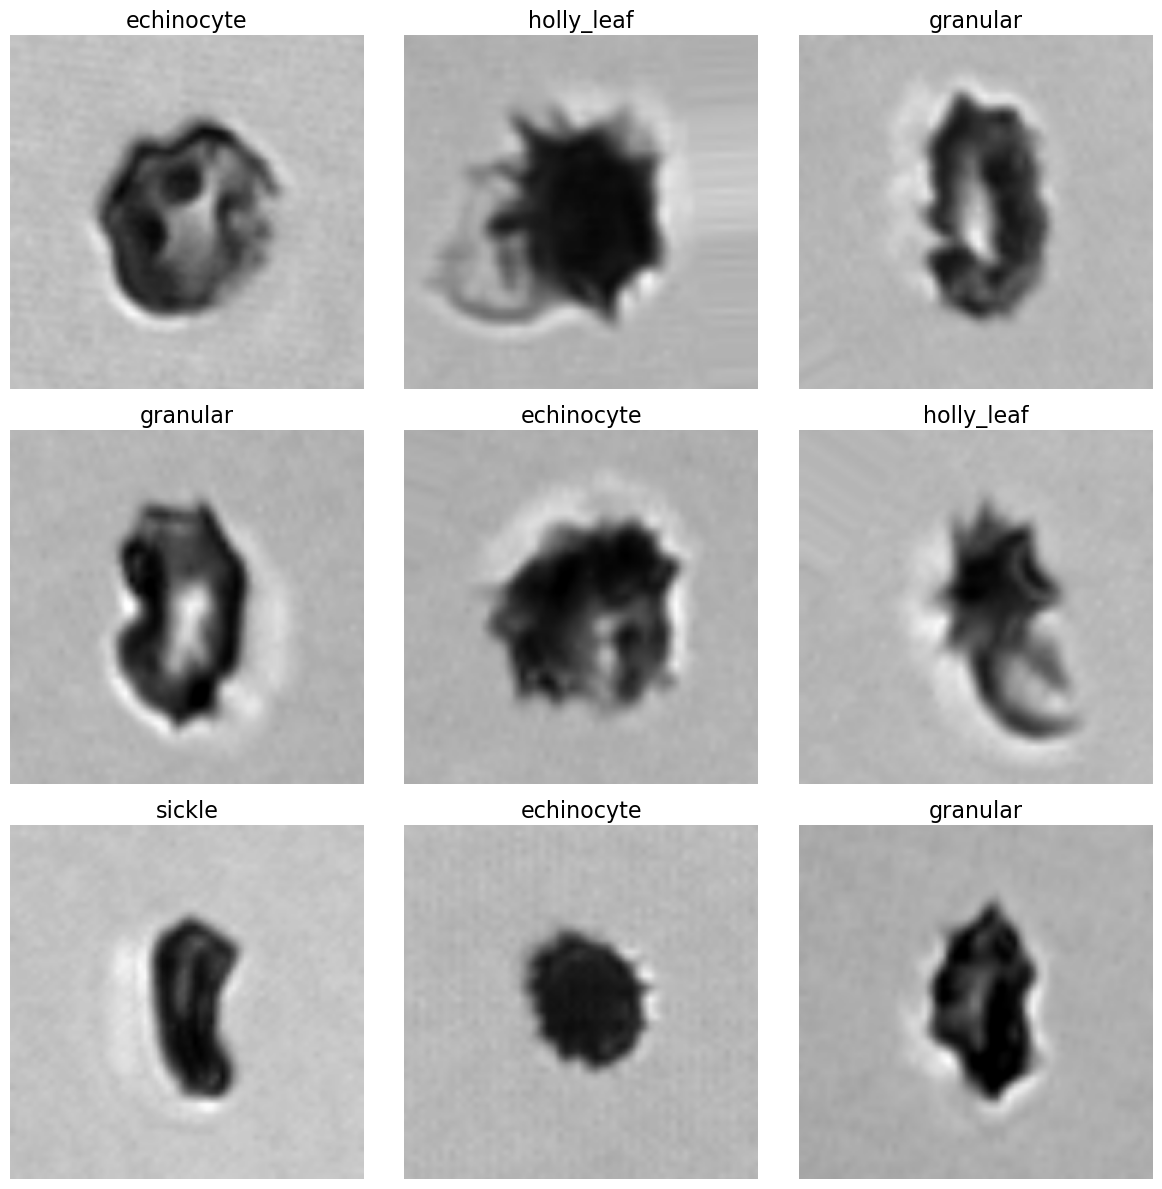

<Figure size 640x480 with 0 Axes>

In [8]:
# Create a figure to display the images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Iterate over the dataset and display 9 random images
for i, (image, label) in enumerate(ds.take(9)):
    ax = axes[i // 3, i % 3]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis("off")
    ax.set_title(
        class_names[tf.argmax(label).numpy()], fontsize=16
    )  # Increased fontsize

plt.tight_layout()
plt.show()
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250208_augmented_images.png",
    bbox_inches="tight",
    dpi=300,
)

Make extra graph for the ImageStream Dataset

   discocyte  echinocyte  sickle  sidewaydiscocytes  granular  holly_leaf
0       6031        2135     779               3563      4404        1325


NameError: name 'sns' is not defined

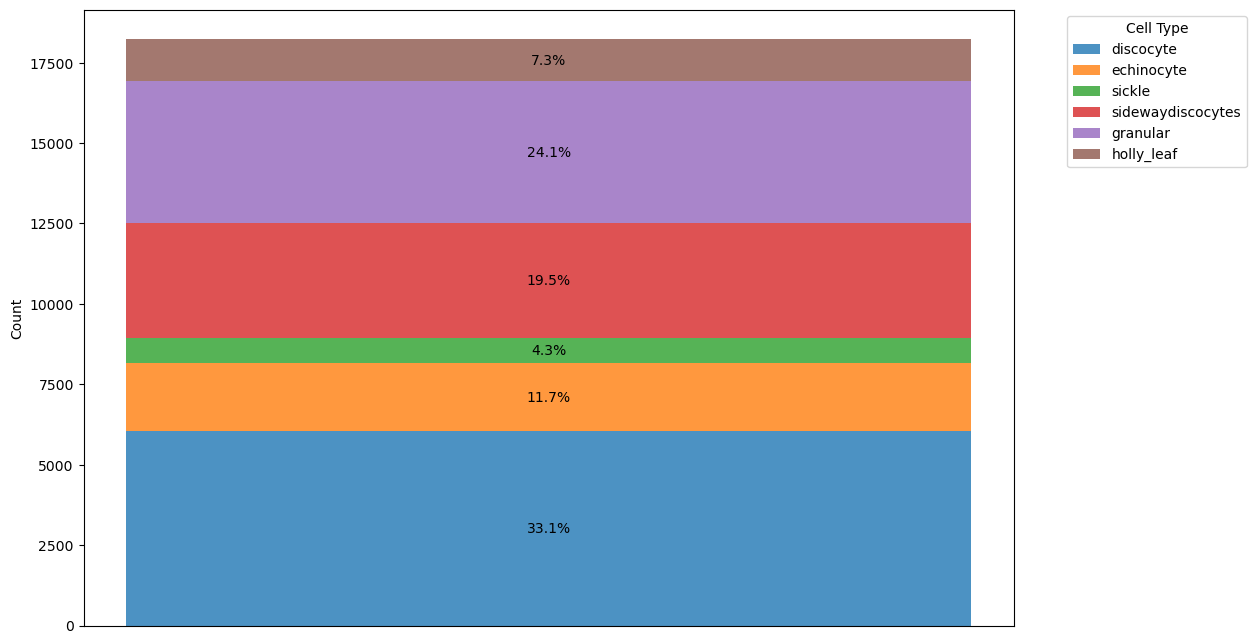

In [3]:
import os

# Define the path to the folders
path_to_folders = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

# Get the list of folders
folders = [
    f
    for f in os.listdir(path_to_folders)
    if os.path.isdir(os.path.join(path_to_folders, f))
]

# Count the items in each folder
folder_counts = {
    folder: len(os.listdir(os.path.join(path_to_folders, folder))) for folder in folders
}

# Create a DataFrame with the counts
df_folder_counts = pd.DataFrame([folder_counts])
print(df_folder_counts)

# Calculate the total counts
df_total = df_folder_counts.sum(axis=1)

# Calculate the relative percentages
df_rel = df_folder_counts.div(df_total, axis=0) * 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of cell types
cell_type_order = df_folder_counts.columns

# Plot each cell type as a stacked bar with thicker bars
bottom = np.zeros(len(df_folder_counts))
for cell_type in cell_type_order:
    ax.bar(
        df_folder_counts.index,
        df_folder_counts[cell_type],
        label=cell_type,
        bottom=bottom,
        width=0.5,
        alpha=0.8,
    )
    bottom += df_folder_counts[cell_type]

# Add percentage labels to the bars
for cell_type in df_rel:
    for i, (cs, ab, pc) in enumerate(
        zip(
            df_folder_counts.cumsum(axis=1)[cell_type],
            df_folder_counts[cell_type],
            df_rel[cell_type],
        )
    ):
        ax.text(i, cs - ab / 2, str(np.round(pc, 1)) + "%", va="center", ha="center")

# Add labels and legend
ax.set_ylabel("Count")
ax.legend(
    title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside

# Remove x label, x ticks, and despine on the left
ax.set_xlabel("")
ax.set_xticks([])
sns.despine(ax=ax, left=True)

# Show the plot
plt.xticks(rotation=45)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250206_cell_count_imagestraem.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

   discocyte  echinocyte  sickle  sidewaydiscocytes  granular  holly_leaf
0       6031        2135     779               3563      4404        1325


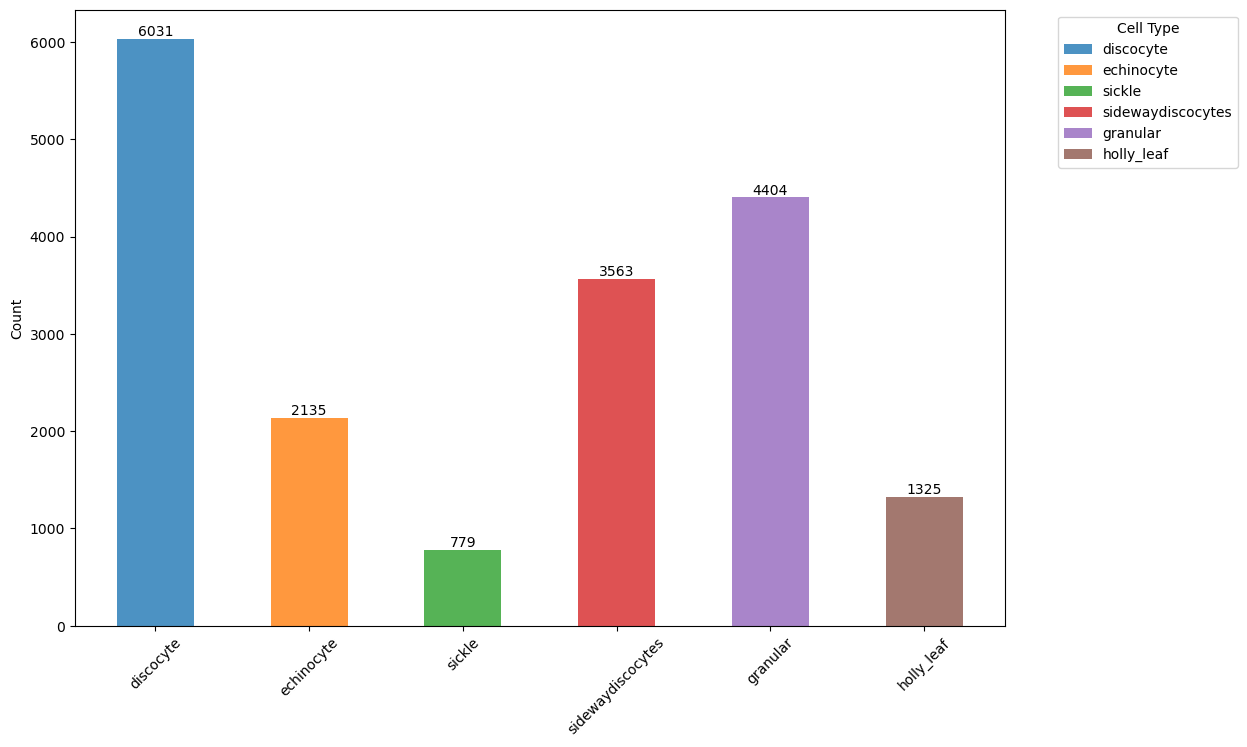

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the folders
path_to_folders = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

# Get the list of folders
folders = [
    f
    for f in os.listdir(path_to_folders)
    if os.path.isdir(os.path.join(path_to_folders, f))
]

# Count the items in each folder
folder_counts = {
    folder: len(os.listdir(os.path.join(path_to_folders, folder))) for folder in folders
}

# Create a DataFrame with the counts
df_folder_counts = pd.DataFrame([folder_counts])
print(df_folder_counts)

# Calculate the total counts
df_total = df_folder_counts.sum(axis=1)

# Calculate the relative percentages
df_rel = df_folder_counts.div(df_total, axis=0) * 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of cell types
cell_type_order = df_folder_counts.columns

# Plot each cell type as a separate bar
for cell_type in cell_type_order:
    count = df_folder_counts[cell_type][0]
    ax.bar(
        cell_type,
        count,
        label=cell_type,
        width=0.5,
        alpha=0.8,
    )
    ax.text(cell_type, count, str(count), ha="center", va="bottom")

# Add labels and legend
ax.set_ylabel("Count")
ax.legend(
    title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside

# Show the plot
plt.xticks(rotation=45)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250206_cell_count_imagestraem.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

   discocyte  echinocyte  granular  holly_leaf  sickle
0       3000         661      1271         784    1946


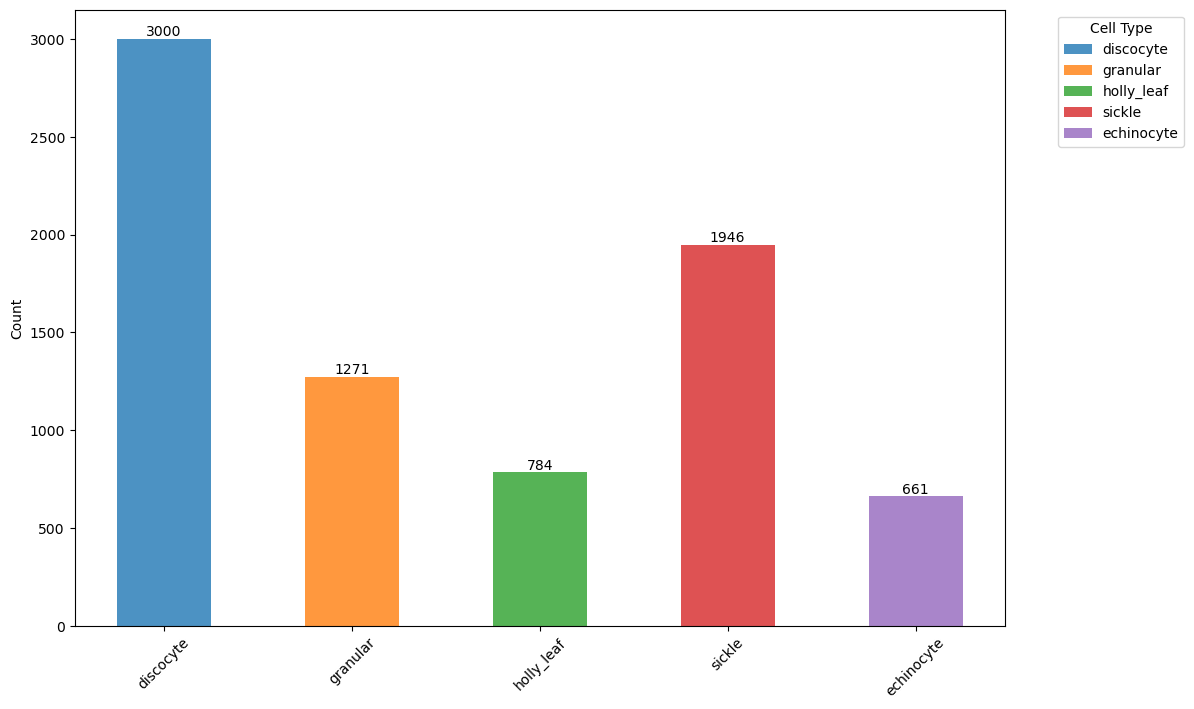

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the folders
path_to_folders = "/home/t.afanasyeva/deep_learning_anaemias/resources/train"

# Get the list of folders
folders = [
    f
    for f in os.listdir(path_to_folders)
    if os.path.isdir(os.path.join(path_to_folders, f))
]

# Count the items in each folder
folder_counts = {
    folder: len(os.listdir(os.path.join(path_to_folders, folder))) for folder in folders
}

# Create a DataFrame with the counts
df_folder_counts = pd.DataFrame([folder_counts])
print(df_folder_counts)

# Calculate the total counts
df_total = df_folder_counts.sum(axis=1)

# Define the new order of columns
new_order = ["discocyte", "granular", "holly_leaf", "sickle", "echinocyte"]


# # Calculate the relative percentages
# df_rel = df_folder_counts.div(df_total, axis=0) * 100

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of cell types
cell_type_order = new_order

# Plot each cell type as a separate bar
for cell_type in cell_type_order:
    count = df_folder_counts[cell_type][0]
    ax.bar(
        cell_type,
        count,
        label=cell_type,
        width=0.5,
        alpha=0.8,
    )
    ax.text(cell_type, count, str(count), ha="center", va="bottom")

# Add labels and legend
ax.set_ylabel("Count")
ax.legend(
    title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside

# Show the plot
plt.xticks(rotation=45)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250206_cell_count_imagestraem.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

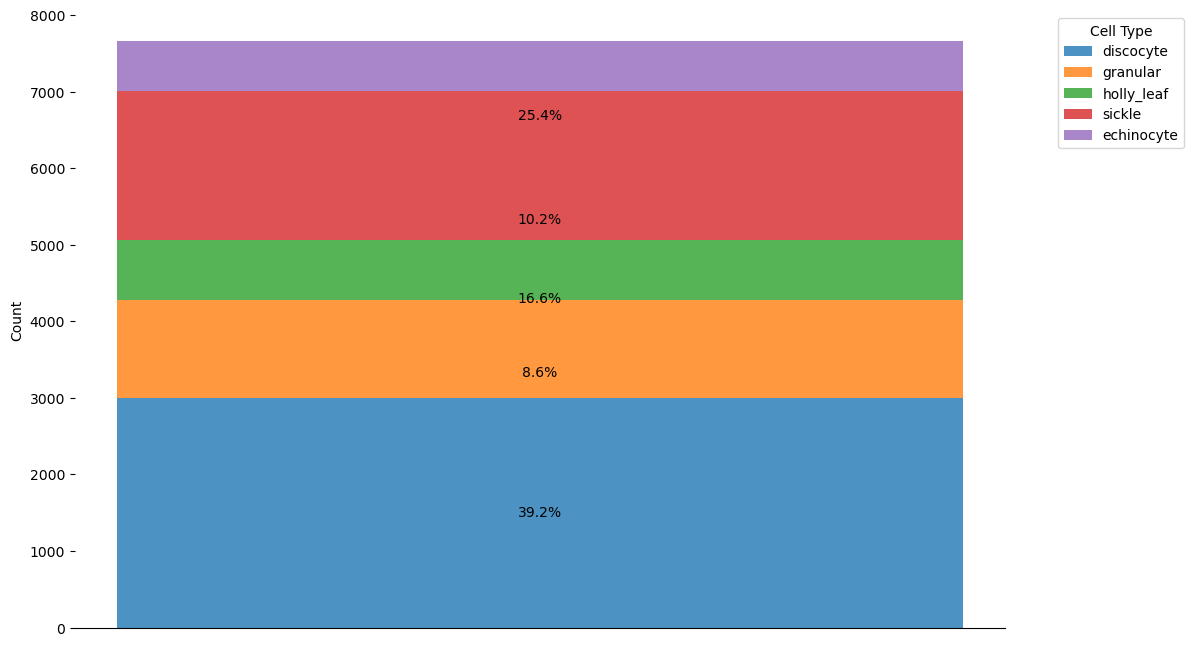

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each cell type as a stacked bar with thicker bars
bottom = np.zeros(len(df_total))
for cell_type in cell_type_order:
    ax.bar(
        df_total.index,
        df_folder_counts[cell_type],
        label=cell_type,
        bottom=bottom,
        width=0.5,
        alpha=0.8,
    )
    bottom += df_folder_counts[cell_type]

# Add percentage labels to the bars
for cell_type in df_rel:
    for i, (cs, ab, pc) in enumerate(
        zip(
            df_folder_counts.cumsum(axis=1)[cell_type],
            df_folder_counts[cell_type],
            df_rel[cell_type],
        )
    ):
        ax.text(i, cs - ab / 2, str(np.round(pc, 1)) + "%", va="center", ha="center")

# Add labels and legend
ax.set_ylabel("Count")
ax.legend(
    title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)  # Move legend outside

# Remove x label, x ticks, and despine on the left
ax.set_xlabel("")
ax.set_xticks([])
sns.despine(ax=ax, left=True)

# Show the plot
plt.xticks(rotation=45)
plt.savefig(
    "/home/t.afanasyeva/deep_learning_anaemias/output/250206_cell_count_cytpix_bar.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()